<a href="https://colab.research.google.com/github/Nazhan99/Tensorflow_notes/blob/main/04_Transfer_learning_in_tensorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer learning with tensorflow part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned pattern for our own data.

The two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data,

In [ ]:
#Are we using a GPU?
!nvidia-smi

Sat Feb 19 06:17:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Download and becoming one with the data

In [ ]:
#Get data (10% of 10 food classes from Food101)
import zipfile

#download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-02-19 06:17:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  50.1MB/s    in 3.2s    

2022-02-19 06:17:05 (50.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#how many images in each folder
import os

#walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")


There are 2 directories and 0 images in '10_food_classes_10_percent'. 
There are 10 directories and 0 images in '10_food_classes_10_percent/train'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'. 
There are 0 directories and 75 images in '10_food_classes_10_perc

# Creating data loaders (preparing the data)

we will ise the ImageDataGenerator class to load in our images in batches.

In [ ]:
#setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size= IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionallity you can add to your models to be performed during or after training. Some of the most popular callbacks:
 
 * Tracking experiments with tensorflow callback
 * Model checkpoint with ModelCheckpoint callback
 * Stopping a model from training (before it trains too long and overfit with EarlyStopping callbacks

In [ ]:
#create TensorBoard callbacks (functionized because we need to create a new one for each model
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d=%H%M%S")
  tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback


## Creating models using Tensorflow Hub
access pretrained model through https://tfhub.dev/

use the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector


In [ ]:
#compare the following two models 
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector"

In [ ]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
#make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a tensorflow hub URL and creates a keras sequential model with it.

  args:
  model_url (str): A tensorflow hub feature extraction url.
  num_classes (int): numbet of output neurons in the output layer,
  should be equal to number of target classes, default 10.

  Returns:
  An uncompiled keras sequential model with model_url as feature extractor
  layer and Dense output layer with num_classes output layers.

  """
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable =False, #free the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  #create our own model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation="softmax", name="output_layer")
  ]) 

  return model

### Creating and testing ResNet tensorflow model

In [ ]:
#create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
#compile the resnet model
resnet_model.compile(loss ="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
#fit the resnet model to the data (10 percent of 10 classes)
resnet_history= resnet_model.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=len(test_data_10_percent),
                                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                        experiment_name="resnet50V2")])

Saving TensorBoard log files to : tensorflow_hub/resnet50V2/20220219=062104
Epoch 1/5
24/24 [==============================] - 23s 971ms/step - loss: 1.2382 - accuracy: 0.6293 - val_loss: 0.9968 - val_accuracy: 0.6844
Epoch 2/5
24/24 [==============================] - 21s 908ms/step - loss: 0.7420 - accuracy: 0.7840 - val_loss: 0.7942 - val_accuracy: 0.7452
Epoch 3/5
24/24 [==============================] - 21s 902ms/step - loss: 0.5352 - accuracy: 0.8493 - val_loss: 0.7383 - val_accuracy: 0.7608
Epoch 4/5
24/24 [==============================] - 21s 897ms/step - loss: 0.4181 - accuracy: 0.8947 - val_loss: 0.6932 - val_accuracy: 0.7764
Epoch 5/5
24/24 [==============================] - 21s 896ms/step - loss: 0.3411 - accuracy: 0.9320 - val_loss: 0.6906 - val_accuracy: 0.7752


In [19]:
# create a function to plot our loss curves
#Tidbit: you could put a function liek this into a script called "helper.py"  and import 
import matplotlib.pyplot as plt

#plot the validation and training curves

def plot_loss_curves(history):
  """
  return separate loss curves for training and validation metrics.

  Args:
  history: TensorFlow History object.

  Returns:
  plots of training/validation loss and accuracy metrics.
  """
  loss=history.history["loss"]
  val_loss= history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();



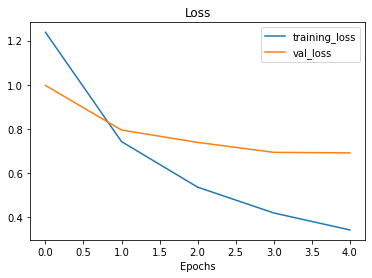

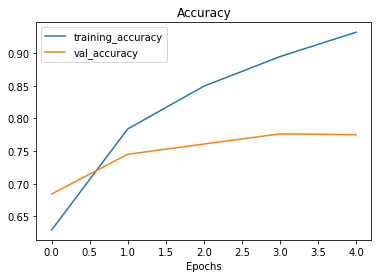

In [20]:
plot_loss_curves(resnet_history)